In [1]:
import os
os.chdir("/Users/qi/Documents/work/iSMD/inverse-reac")
import xenonpy
xenonpy.__version__
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# load in-house data
data = pd.read_csv("./STEREO_reactant_product_xlogp_tpsa_1000.csv")

In [3]:
# take a look at the data
data.columns
data.head()

,reactant,product,XLogP,TPSA
0,CCS(=O)(=O)Cl.OCCBr,CCS(=O)(=O)OCCBr,0.8,51.8
1,CC(C)CS(=O)(=O)Cl.OCCCl,CC(C)CS(=O)(=O)OCCCl,1.6,51.8
2,O=[N+]([O-])c1cccc2cnc(Cl)cc12,Nc1cccc2cnc(Cl)cc12,2.4,38.9
3,Cc1cc2c([N+](=O)[O-])cccc2c[n+]1[O-].O=P(Cl)(C...,Cc1cc2c([N+](=O)[O-])cccc2c(Cl)n1,3.3,58.7
4,CCCCC[C@H](O)C=CC1C=CC(=O)C1CC=CCCCC(=O)O,CCCCC[C@H](O)C=CC1CCC(=O)C1CC=CCCCC(=O)O,3.8,74.6


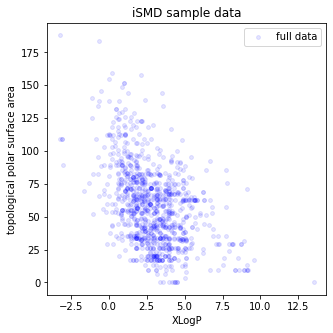

In [4]:
# check target properties: XLogP & TPSA gap
plt.figure(figsize=(5,5))
plt.scatter(data['XLogP'],data['TPSA'],s=15,c='b',alpha = 0.1,label="full data")
plt.legend(loc='upper right')
plt.title('iSMD sample data')
plt.xlabel('XLogP')
plt.ylabel('topological polar surface area')
plt.show()

In [5]:
# SMILES to Fingerprint
from xenonpy.descriptor import Fingerprints
RDKit_FPs = Fingerprints(featurizers=['ECFP', 'MACCS'], input_type='smiles')
tmp_FPs = RDKit_FPs.transform(data['product'])
print(tmp_FPs.head())

   maccs:0  maccs:1  maccs:2  maccs:3  maccs:4  maccs:5  maccs:6  maccs:7  \
0        0        0        0        0        0        0        0        0   
1        0        0        0        0        0        0        0        0   
2        0        0        0        0        0        0        0        0   
3        0        0        0        0        0        0        0        0   
4        0        0        0        0        0        0        0        0   

   maccs:8  maccs:9  ...  ecfp3:2038  ecfp3:2039  ecfp3:2040  ecfp3:2041  \
0        0        0  ...           0           0           0           0   
1        0        0  ...           0           0           0           0   
2        0        0  ...           0           0           0           0   
3        0        0  ...           0           0           0           0   
4        0        0  ...           0           0           0           0   

   ecfp3:2042  ecfp3:2043  ecfp3:2044  ecfp3:2045  ecfp3:2046  ecfp3:2047  
0   

In [6]:
# Load estimator
from ismd import GaussianLogLikelihood
# Load modifier
from ismd import PoolSampler

In [7]:
# Set target region
prop = ['XLogP','TPSA']
target_range = {'XLogP': (-2,2), 'TPSA': (0, 25)}

In [8]:
# forward models
prd_mdls = GaussianLogLikelihood(descriptor=RDKit_FPs, targets = target_range)
prd_mdls.fit(data['product'], data[prop])

In [9]:
# Modifier
reactant_pool = [line.rstrip('\n') for line in open("/Users/qi/Documents/work/iSMD/data/STEREO_pool.txt")] #len(reactant_pool)=637645
reactant_pool1000=reactant_pool[:1000]
pool_sampler = PoolSampler(reactant_pool=reactant_pool1000)

In [10]:
# Reactor
from ismd import Reactor
ChemicalReactor = Reactor()       
ChemicalReactor.BuildReactor(model_list=['./ismd/transformer_models/STEREO_mixed_augm_model_average_20.pt'], max_length=100, n_best=1) 

In [11]:
# Initial generation
cans = [smi for i, smi in enumerate(data['reactant'])
       if (data['XLogP'].iloc[i] > 4)]
init_samples = np.random.choice(cans, 10)
print(init_samples)

['ClCCCN1CCN(Cc2ccc(Br)cc2)CC1.O=C1CCCc2c(O)cccc21'
 'O=S(Cl)Cl.OCc1cccc2cc(Br)ccc12'
 'CCOc1ccccc1N1CCN(CCCCl)CC1.O=C1CCCc2c(O)cccc21'
 'COc1ccc(N2CCN(CCCCl)CC2)cc1.O=C1CCCc2c(O)cccc21' 'Cc1ccc(C)cc1.[Li]CCCC'
 'CN(C)C=O.O=C(O)c1cc(-n2c(-c3ccc(Br)cc3)cc3c2CCCC3)ccc1O'
 'C=C.CC(=O)O.CC(=O)[O-].CC(C)(C)c1ccccc1'
 'ClC(Cl)(Cl)c1nc(C(Cl)(Cl)Cl)nc(C(Cl)(Cl)Cl)n1.NCc1ccccc1'
 'CN(C)C=O.O=C1CCC2(CC1)Cc1ccccc1C2.[N-]=[N+]=[N-]'
 'CC(C)=O.CCCCCC(CC[C@H]1CCC(=O)[C@@H]1CCCCCCC(=O)OCC)OS(C)(=O)=O.O=C([O-])Cc1cccs1']


In [12]:
# Main routine
from ismd import ISMD

ismd_main = ISMD(estimator=prd_mdls, modifier=pool_sampler, reactor=ChemicalReactor)

In [13]:
for reac,product,tmp in ismd_main(init_samples,target_range):
    print(init_samples)
    print(product)
    print(tmp)

Generation: 0


/usr/local/miniconda3/envs/ismdd/lib/python3.6/site-packages/torchtext/data/field.py:359: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  var = torch.tensor(arr, dtype=self.dtype, device=device)
/Users/distiller/project/conda/conda-bld/pytorch_1591914889657/work/aten/src/ATen/native/BinaryOps.cpp:81: UserWarning: Integer division of tensors using div or / is deprecated, and in a future release div will perform true division as in Python 3. Use true_divide or floor_divide (// in Python) instead.


['ClCCCN1CCN(Cc2ccc(Br)cc2)CC1.O=C1CCCc2c(O)cccc21'
 'O=S(Cl)Cl.OCc1cccc2cc(Br)ccc12'
 'CCOc1ccccc1N1CCN(CCCCl)CC1.O=C1CCCc2c(O)cccc21'
 'COc1ccc(N2CCN(CCCCl)CC2)cc1.O=C1CCCc2c(O)cccc21' 'Cc1ccc(C)cc1.[Li]CCCC'
 'CN(C)C=O.O=C(O)c1cc(-n2c(-c3ccc(Br)cc3)cc3c2CCCC3)ccc1O'
 'C=C.CC(=O)O.CC(=O)[O-].CC(C)(C)c1ccccc1'
 'ClC(Cl)(Cl)c1nc(C(Cl)(Cl)Cl)nc(C(Cl)(Cl)Cl)n1.NCc1ccccc1'
 'CN(C)C=O.O=C1CCC2(CC1)Cc1ccccc1C2.[N-]=[N+]=[N-]'
 'CC(C)=O.CCCCCC(CC[C@H]1CCC(=O)[C@@H]1CCCCCCC(=O)OCC)OS(C)(=O)=O.O=C([O-])Cc1cccs1']
['O=C1CCCc2c(OCCCN3CCN(Cc4ccc(Br)cc4)CC3)cccc21', 'ClCc1cccc2cc(Br)ccc12', 'CCOc1ccccc1N1CCN(CCCOc2cccc3c2CCCC3=O)CC1', 'COc1ccc(N2CCN(CCCOc3cccc4c3CCCC4=O)CC2)cc1', '[Li]Cc1ccc(C)cc1', 'N#Cc1ccc(-c2cc3c(n2-c2ccc(O)c(C(=O)O)c2)CCCC3)cc1', 'CC(C)(C)c1ccc(CCO)cc1', 'ClC(Cl)(Cl)c1nc(NCc2ccccc2)nc(C(Cl)(Cl)Cl)n1', '[N-]=[N+]=NC1CCC2(CCc3ccccc3C2)CC1', 'CCCCCC(CC[C@H]1CCC(=O)[C@@H]1CCCCCCC(=O)OCC)SC(C)=O']
         XLogP           TPSA
0  -512.105316  -1.400438e+02
1  -325.353320  -6.93187

/usr/local/miniconda3/envs/ismdd/lib/python3.6/site-packages/torchtext/data/field.py:359: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  var = torch.tensor(arr, dtype=self.dtype, device=device)


['ClCCCN1CCN(Cc2ccc(Br)cc2)CC1.O=C1CCCc2c(O)cccc21'
 'O=S(Cl)Cl.OCc1cccc2cc(Br)ccc12'
 'CCOc1ccccc1N1CCN(CCCCl)CC1.O=C1CCCc2c(O)cccc21'
 'COc1ccc(N2CCN(CCCCl)CC2)cc1.O=C1CCCc2c(O)cccc21' 'Cc1ccc(C)cc1.[Li]CCCC'
 'CN(C)C=O.O=C(O)c1cc(-n2c(-c3ccc(Br)cc3)cc3c2CCCC3)ccc1O'
 'C=C.CC(=O)O.CC(=O)[O-].CC(C)(C)c1ccccc1'
 'ClC(Cl)(Cl)c1nc(C(Cl)(Cl)Cl)nc(C(Cl)(Cl)Cl)n1.NCc1ccccc1'
 'CN(C)C=O.O=C1CCC2(CC1)Cc1ccccc1C2.[N-]=[N+]=[N-]'
 'CC(C)=O.CCCCCC(CC[C@H]1CCC(=O)[C@@H]1CCCCCCC(=O)OCC)OS(C)(=O)=O.O=C([O-])Cc1cccs1']
['CCCCOc1ccc(NC(C)=O)cc1NC(C)=O', '[Li]N1CCc2cc3c(cc21)C1(CCN(C)CC1)CO3', 'C[C@@H]1CN(c2nnc(-c3ccccc3)c3ccncc23)CCN1', 'C=Cc1cccc(N)c1', 'COc1cc(Nc2c(C#N)cnc3cc(F)c(OC)cc23)c(Cl)cc1Cl', '[Li]c1c(C)cccc1C', 'CCCCC(=O)c1ccc(OC(C)C)cc1', '[Li]C#Cc1cc(C)cc(Nc2nccc(C(F)F)n2)c1', 'N[C@H]1CC=CC[C@@H](CC(=O)NCc2ccc(Cl)cc2)C(=O)NC[C@@H](c2ccccc2)OC1=O', 'Cc1ccc(C)c(C(=O)c2ccc(Cl)c(Cl)c2)c1']
        XLogP          TPSA
0   -1.166555 -6.230100e+02
1  -16.042477 -1.020886e+00
2  -27.007876 -4.45

/usr/local/miniconda3/envs/ismdd/lib/python3.6/site-packages/torchtext/data/field.py:359: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  var = torch.tensor(arr, dtype=self.dtype, device=device)


['ClCCCN1CCN(Cc2ccc(Br)cc2)CC1.O=C1CCCc2c(O)cccc21'
 'O=S(Cl)Cl.OCc1cccc2cc(Br)ccc12'
 'CCOc1ccccc1N1CCN(CCCCl)CC1.O=C1CCCc2c(O)cccc21'
 'COc1ccc(N2CCN(CCCCl)CC2)cc1.O=C1CCCc2c(O)cccc21' 'Cc1ccc(C)cc1.[Li]CCCC'
 'CN(C)C=O.O=C(O)c1cc(-n2c(-c3ccc(Br)cc3)cc3c2CCCC3)ccc1O'
 'C=C.CC(=O)O.CC(=O)[O-].CC(C)(C)c1ccccc1'
 'ClC(Cl)(Cl)c1nc(C(Cl)(Cl)Cl)nc(C(Cl)(Cl)Cl)n1.NCc1ccccc1'
 'CN(C)C=O.O=C1CCC2(CC1)Cc1ccccc1C2.[N-]=[N+]=[N-]'
 'CC(C)=O.CCCCCC(CC[C@H]1CCC(=O)[C@@H]1CCCCCCC(=O)OCC)OS(C)(=O)=O.O=C([O-])Cc1cccs1']
['COCCCOc1cc(C[C@@H](C[C@H]2[C@H](C[C@H](C(=O)NCC(C)(C)C(N)=O)C(C)C)OCN2C(=O)OCC=Cc2cccc([N+](=O)[O-])c2)C(C)C)ccc1OC', 'CCCCC(=O)C(C)(CO)C(c1ccccc1)c1ccc2c(cnn2-c2ccc(F)cc2)c1', 'CCCCCN1CCC2(CC1)COc1cc3c(cc12)NCC3', '[Li]c1sc(SC)nc1-c1cc(C(C)(C)C)c(O)c(C(C)(C)C)c1', 'CCCCC(O)(c1cccc(Br)c1)C1(c2cccc(Br)c2)CCCC1', 'CC(NC(=O)OCc1ccccc1)C(C)NC(=O)c1ccccc1OCCN1CCc2cc3c(cc21)C1(CCN(C)CC1)CO3', 'Cc1nc(OCCCCN2CCc3cc4c(cc32)C2(CCN(C)CC2)CO4)nc2c1ccc(=O)n2C', 'CN1CCC2(CC1)COc1cc3c(cc12)N(CCC1O

/usr/local/miniconda3/envs/ismdd/lib/python3.6/site-packages/torchtext/data/field.py:359: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  var = torch.tensor(arr, dtype=self.dtype, device=device)


['ClCCCN1CCN(Cc2ccc(Br)cc2)CC1.O=C1CCCc2c(O)cccc21'
 'O=S(Cl)Cl.OCc1cccc2cc(Br)ccc12'
 'CCOc1ccccc1N1CCN(CCCCl)CC1.O=C1CCCc2c(O)cccc21'
 'COc1ccc(N2CCN(CCCCl)CC2)cc1.O=C1CCCc2c(O)cccc21' 'Cc1ccc(C)cc1.[Li]CCCC'
 'CN(C)C=O.O=C(O)c1cc(-n2c(-c3ccc(Br)cc3)cc3c2CCCC3)ccc1O'
 'C=C.CC(=O)O.CC(=O)[O-].CC(C)(C)c1ccccc1'
 'ClC(Cl)(Cl)c1nc(C(Cl)(Cl)Cl)nc(C(Cl)(Cl)Cl)n1.NCc1ccccc1'
 'CN(C)C=O.O=C1CCC2(CC1)Cc1ccccc1C2.[N-]=[N+]=[N-]'
 'CC(C)=O.CCCCCC(CC[C@H]1CCC(=O)[C@@H]1CCCCCCC(=O)OCC)OS(C)(=O)=O.O=C([O-])Cc1cccs1']
['CCCCCNCC1(NC(=O)OC(C)(C)C)COC(C)(C)OC1', 'CCCCCNC(=O)[C@H](Cc1c(C)cc(OCc2sc(-c3ccc(C(F)(F)F)cc3)nc2C)cc1C)OCC', 'CCCCCNC(=O)C[C@H](NC(=O)OC(C)(C)C)C(=O)OCc1ccccc1', 'CCCCCNc1ccc2c(C)c(C)[nH]c2c1', 'CN1CCC2(CC1)COc1cc3c(cc12)N(CCC=C1c2cc(OC(C)(C)C(=O)O)ccc2OCc2ncccc21)CC3', 'CCCCCNC1CCN(Cc2ccccc2)CC1CCC', 'CCCCCNc1cc(C#N)c(N[C@@H](CO)c2ccc(F)cc2)nc1Nc1cc(C2CC2)[nH]n1', 'CCCCCNC(=O)c1ccc(C(c2cccc3cccnc23)N2CCNCC2)cc1', 'CN1CCC2(CC1)COc1cc3c(cc12)N(CCN)CC3', 'Cc1nc2c(N)cc(C(=O)N3CCc4cc

/usr/local/miniconda3/envs/ismdd/lib/python3.6/site-packages/torchtext/data/field.py:359: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  var = torch.tensor(arr, dtype=self.dtype, device=device)


['ClCCCN1CCN(Cc2ccc(Br)cc2)CC1.O=C1CCCc2c(O)cccc21'
 'O=S(Cl)Cl.OCc1cccc2cc(Br)ccc12'
 'CCOc1ccccc1N1CCN(CCCCl)CC1.O=C1CCCc2c(O)cccc21'
 'COc1ccc(N2CCN(CCCCl)CC2)cc1.O=C1CCCc2c(O)cccc21' 'Cc1ccc(C)cc1.[Li]CCCC'
 'CN(C)C=O.O=C(O)c1cc(-n2c(-c3ccc(Br)cc3)cc3c2CCCC3)ccc1O'
 'C=C.CC(=O)O.CC(=O)[O-].CC(C)(C)c1ccccc1'
 'ClC(Cl)(Cl)c1nc(C(Cl)(Cl)Cl)nc(C(Cl)(Cl)Cl)n1.NCc1ccccc1'
 'CN(C)C=O.O=C1CCC2(CC1)Cc1ccccc1C2.[N-]=[N+]=[N-]'
 'CC(C)=O.CCCCCC(CC[C@H]1CCC(=O)[C@@H]1CCCCCCC(=O)OCC)OS(C)(=O)=O.O=C([O-])Cc1cccs1']
['CCCC1CN(Cc2ccccc2)CCC1NCC1C(=O)Nc2ccccc21', 'CCCC1CN(Cc2ccccc2)CCC1Nc1cccc(Nc2ncc(C)c(-c3sc(SC)c(C#N)c3C3CCCCC3)n2)c1', 'CCCCCNc1c(CC#N)cc(F)c2c1OCCO2', 'CCCCCNc1ncnc2sc(C(C)C)cc12', 'CCCC1CN(Cc2ccccc2)CCC1(O)c1cnc(C)s1', 'CCCC1CN(Cc2ccccc2)CCC1N1CCN(c2nc(-c3ccnc(Cl)c3)cc3cnccc23)CC1', 'CCCCCNC(=O)CNCCCn1c(-c2ccc(F)cc2)csc1=Nc1ccc(Cl)cc1OC', 'CCCCCNC(=O)Cc1ccc(CS(N)(=O)=O)cc1', 'CCCC1CN(Cc2ccccc2)CCC1Nc1nc(-n2cc(C(=O)O)c(=O)c3cc(F)c(F)c(Cl)c32)c(Cl)cc1F', 'CCCC1CN(Cc2ccccc2)CCC1Nc1n